# Vis Generation Notebook

For creating memo and report visualizations.

In [14]:
# imports
import boto3
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point
import sys  # Used for progress bar
from case_study_eval_utils import *
from figure_utils import *
import datetime
import sys
import os

# Import qaqc stage plot functions
sys.path.append(os.path.abspath("../scripts/3_qaqc_data"))
from qaqc_plot import flagged_timeseries_plot, _plot_format_helper, id_flag


# Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client("s3")  # for lower-level processes

# Set relative paths to other folders and objects in repository.
BUCKET_NAME = "wecc-historical-wx"
QAQC_DIR = "3_qaqc_wx"
MERGE_DIR = "4_merge_wx"
stations_csv_path = f"s3://{BUCKET_NAME}/{QAQC_DIR}/all_network_stationlist_qaqc.csv"

## Setup

In [15]:

# read in merge station list
stn_list = pd.read_csv(
    "s3://wecc-historical-wx/4_merge_wx/all_network_stationlist_merge.csv"
)

In [16]:
# convert it into geodataframe
stns_gdf = gpd.GeoDataFrame(
    stn_list,
    geometry=gpd.points_from_xy(stn_list.longitude, stn_list.latitude, crs="EPSG:4326"),
)

## Comparison Map

In [17]:
# load california state boundary
state_boundaries = gpd.read_file("s3://wecc-historical-wx/0_maps/tl_2021_us_state/")
ca_boundary = state_boundaries[state_boundaries["NAME"] == ("California")]
ca_boundary = ca_boundary.to_crs(stns_gdf.crs)

In [18]:
# filter station list to those located in California
ca_stations = stns_gdf.clip(ca_boundary)

In [ ]:
# grab stations that only have solar radiation or wind
# rsds, sfcWind, sfcWind_dir
ca_stations['contains_target_vars'] = (ca_stations["sfcwind_nobs"] > 0) | (ca_stations["sfcwind_dir_nobs"] > 0) | (
    ca_stations["rsds_nobs"] > 0
)
dict = {True: "hello", False: "goodbye"}
ca_stations = ca_stations.replace({"contains_target_vars": dict})

/home/machuca/miniconda3/envs/hist-obs/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


/home/machuca/miniconda3/envs/hist-obs/lib/python3.10/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


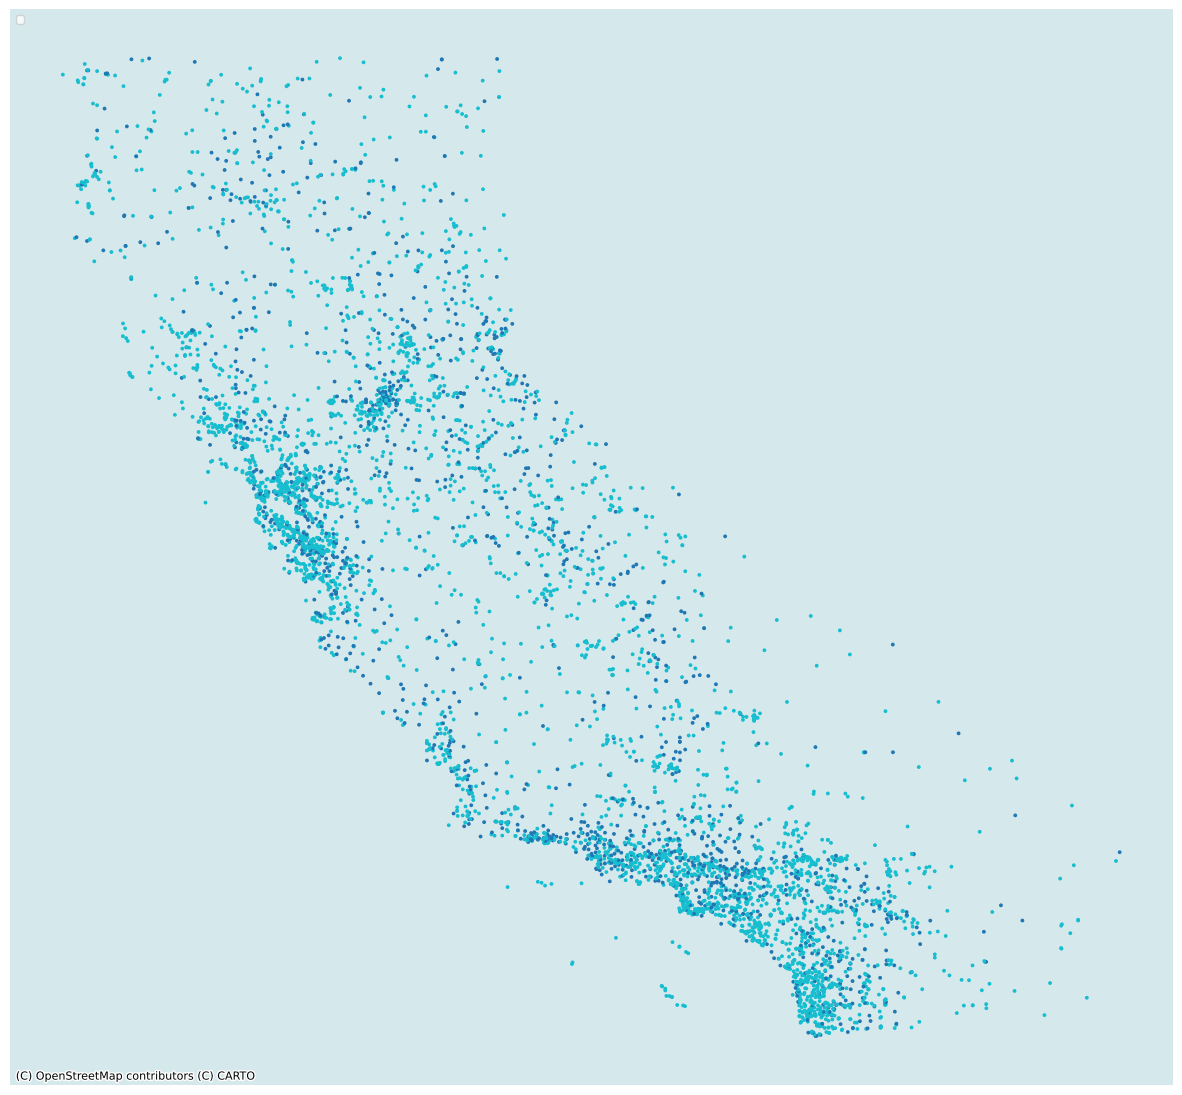

In [36]:
ax = ca_stations.plot(
    "contains_target_vars",
    figsize=(15, 15),
    alpha=1,
    markersize=3,
    legend=True,
    # label="Comparison Between",
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)
ax.set_axis_off()

legend = ax.legend(loc="upper left", prop={"size": 8})

In [41]:
# grab stations that only have solar radiation or wind
# rsds, sfcWind, sfcWind_dir
stn_list["contains_target_vars"] = (
    (stn_list["sfcwind_nobs"] > 0)
    | (stn_list["sfcwind_dir_nobs"] > 0)
    | (stn_list["rsds_nobs"] > 0)
)
dict = {True: "hello", False: "goodbye"}
stn_list = stn_list.replace({"contains_target_vars": dict})

In [44]:
def latlon_to_mercator_cartopy(lat, lon):
    proj_latlon = CRS("EPSG:4326")
    proj_mercator = CRS("EPSG:3857")

    # Transform the coordinates
    transformer = Transformer.from_crs(proj_latlon, proj_mercator, always_xy=True)
    x, y = transformer.transform(lon, lat)

    return x, y

In [45]:
geometry = [
    Point(latlon_to_mercator_cartopy(lat, lon))
    for lat, lon in zip(stn_list.latitude, stn_list.longitude)
]
pr_stns = gpd.GeoDataFrame(stn_list, geometry=geometry).set_crs(
    crs="EPSG:3857", allow_override=True
)  # adding geometry column
pr_stns = gpd.overlay(pr_stns, ca_boundary, how="intersection")

/tmp/ipykernel_5147/1901745606.py:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3857
Right CRS: EPSG:4326

  pr_stns = gpd.overlay(pr_stns, ca_boundary, how="intersection")


/home/machuca/miniconda3/envs/hist-obs/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/machuca/miniconda3/envs/hist-obs/lib/python3.10/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


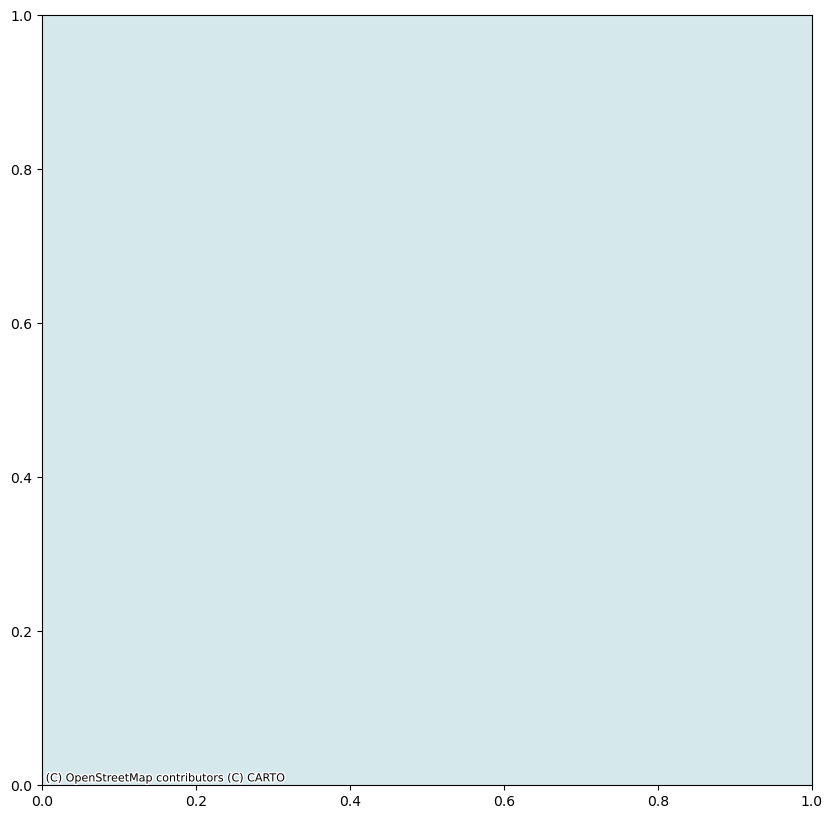

In [47]:
ax = pr_stns.plot(column="contains_target_vars", markersize=8, legend=True, figsize=(10, 10))
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)